Web scraping indeed website for data science jobs based on Greg Reda's [excellent tutorial](http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/) and Jesse Steinweg's [excellent analysis](https://jessesw.com/Data-Science-Skills/) and finally, Sung Pil Moon's [awesome analysis](http://blog.nycdatascience.com/students-work/project-3-web-scraping-company-data-from-indeed-com-and-dice-com/)

## 1) Admin and Setup

I've already created a virtual environment in conda by downloading bs4. Please feel free to use my environment.yaml to create a similar virtual env. I'll update it as I go.

In [50]:
from bs4 import BeautifulSoup
from urllib2 import urlopen
import pandas as pd
import re
import numpy as np
from time import sleep
%matplotlib inline
import pylab as plt

## 2) What do I want to achieve

http://au.indeed.com/jobs?as_and=&as_phr=&as_any=%22customer+analytics%22+%22data+analysis%22&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=50&l=&fromage=any&limit=10&sort=&psf=advsrch

OR

http://au.indeed.com/jobs?as_and=&as_phr=&as_any=%22customer+analytics%22+%22data+analysis%22&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=0&l=Sydney+NSW&fromage=last&limit=10&sort=&psf=advsrch

in a nice tabular format for data exploration

## 3) String together webpage url based on different parameters

Create logic for converting different search parameters such as search query, city, salary etc. as separate lists and then stringing them together into one final query

final_query = base_url + job_query_string + company_name + salary + location + fromage

#### Base URL

In [2]:
# start of the url - this will not change because I'm including search query to search
# anywhere in the job ad. Not just the job title.
base_url = 'http://au.indeed.com/jobs?as_and=&as_phr=&as_any='

#### Job query string inputs as parameters are stored in job_query1, 2 and 3. Restrict to only 3 parameters. 

Step1 - collect 3 search queries<br/>
When you refactor this, make sure this is converted into parameters

In [3]:
#job_query1 = 'data scientist'
#job_query2 = 'customer analytics'
#job_query3 = 'data analysis'
job_query1 = 'test analyst'
job_query2 = 'automation'
job_query3 = 'business analyst'

Step2 - create query string in the required format

In [4]:
# 1) within search string, spaces are replaced by '+' in html
# 2) each search query is preceded and succeeded by a "%22"
# 3) string the elements of the list into one string separated by a "+"
job_query_string = []
job_query_string.append("%22" + job_query1.replace(" ","+") + "%22")
job_query_string.append("%22" + job_query2.replace(" ","+") + "%22")
job_query_string.append("%22" + job_query3.replace(" ","+") + "%22")
job_query_string = "+".join(job_query_string)
job_query_string

'%22test+analyst%22+%22automation%22+%22business+analyst%22'

#### Company name, salary, location, fromage - not working on these right now

In [5]:
company_name=''
salary=''
location=''
fromage='any'

#### Create final query

In [6]:
final_query = [base_url,job_query_string,'&as_not=&as_ttl=&as_cmp=',company_name,
               '&jt=all&st=&salary=',salary,'&radius=50&l=',location,
               '&fromage=',fromage,'&limit=10&sort=&psf=advsrch']
final_query = "".join(final_query)
final_query

'http://au.indeed.com/jobs?as_and=&as_phr=&as_any=%22test+analyst%22+%22automation%22+%22business+analyst%22&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=50&l=&fromage=any&limit=10&sort=&psf=advsrch'

## 4) Open website and read it

Step1: Open the first page <br/>
Step2: Get the html of the first page

In [7]:
html = urlopen(final_query).read()  
soup = BeautifulSoup(html, "lxml")

Step3: find out how many jobs returned from the search query

In [8]:
number_of_jobs_page_area = soup.find(id="searchCount").string.encode('utf-8')
number_of_jobs_page_area.replace(',','')

'Jobs 1 to 10 of 2929'

In [9]:
number_of_jobs = re.findall('\d+', number_of_jobs_page_area.replace(',',''))
number_of_jobs

['1', '10', '2929']

In [10]:
total_number_of_jobs = int(number_of_jobs[2])
total_number_of_jobs

2929

Step4: calculate how many pages to scroll

In [11]:
#round up the # of records divided by 10 as the number of pages in order to ensure coverage. 
number_of_pages_to_scroll = np.ceil(total_number_of_jobs/10.0)
number_of_pages_to_scroll

293.0

## 5) Load all the deets into separate lists

In [12]:
# get all the deets of each row. One row pertains to one job
# incidentally, i noticed that the class "row result" was only picking 9 results in the first page.
# this was because the last row was populated in another class 'lastRow row result'

targetElements = soup.findAll('div', attrs = {'class' : ' row result'})
targetElements.extend(soup.findAll('div', attrs = {'class' : 'lastRow row result'}))

In [13]:
type(targetElements)

bs4.element.ResultSet

In [14]:
for elem in targetElements:
    #print elem # commenting out this line so as to remove metadata from the notebook
    print "\n"
    print "*****************************************************"
    print "\n"



*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




*****************************************************




#### Job Title

In [15]:
jobtitle = []
for elem in targetElements:
    #print elem.find('a', attrs = {'class':'turnstileLink'}).attrs['title']
    jobtitle.append(elem.find('a', attrs = {'class':'turnstileLink'}).attrs['title'])

jobtitle

[u'Business Analyst/Project Co-ordinator \u2013 My Learning Space (Prospect)',
 'Project Business Analyst',
 'Business Analyst - My Roster Project',
 'Technical Business Analyst (Project Manager)',
 'Project Business Analyst (12 month contract)',
 'Project Business Analyst',
 'Business Analyst Training + Live Project +100 % Job Assistance',
 u'Test Analyst \u2013 Performance Testing (Cards & Payments)',
 'Business Analyst',
 'Business Analyst']

#### Company Name

In [16]:
companyname = []
for elem in targetElements:
    if elem.find('span', attrs = {'itemprop':'name'}) is None:
        companyname.append(None)
    else:
        companyname.append(elem.find('span', attrs = {'itemprop':'name'})
                                     .getText().strip().encode('utf-8'))    
companyname

['Boral Industries',
 'ANZ Banking Group',
 'Epworth Healthcare',
 'Cashrewards',
 'Metcash',
 'BankVic',
 'Ichip Solutions',
 'Fortune Select',
 'Telstra',
 'CSIRO']

#### Location

In [17]:
location = []
for elem in targetElements:
    location.append(elem.find('span', attrs = {'itemprop':'addressLocality'}).getText().strip().encode('utf-8'))

location

['Sydney NSW',
 'Melbourne VIC',
 'Richmond VIC',
 'Australia',
 'New South Wales',
 'Carlton VIC',
 'Melbourne VIC',
 'Sydney NSW',
 'Sydney NSW',
 'Australia']

#### Summary

In [18]:
summary = []
for elem in targetElements:
    summary.append(elem.find('span', attrs = {'class':'summary'}).getText().strip().encode('utf-8'))
    
summary

['Experienced Business Analyst/Project. In business testing validation of requirements. Learning Space project and collaborating with business stakeholders to....',
 'Proven years of experience in Business Analysis, preferably with experience in Project transition to BAU or Business Analysis in a BAU function....',
 'Developing and refining specifications and business test cases. Core business analysis skills including problem definition, requirements gathering, test...',
 'Minimum 3 years experience in a Technical Business Analyst role or similar. Gather business, application and user requirements....',
 'As a critical part of the business transformation team, the Project Business Analyst will work closely with key stakeholders to provide in-depth analysis and...',
 'We are currently recruiting for the role of Project Business Analyst. Tertiary qualification in a business related discipline....',
 '_Join us to shape your career in IT industry in the high demanding roles of Software Te

#### Company Rating

In [19]:
## cant seem to get this to work for some reason
company_rating = []
for elem in targetElements:
    if elem.find('span', attrs = [{'class':'ratingNumber'}]) is None:
        company_rating.append(None)
    else:
        company_rating.append(elem.find('span', attrs = {'class':'ratingNumber'})
                                     .getText().strip().encode('utf-8'))
    
company_rating

[None, None, None, None, None, None, None, None, None, None]

#### Company rating - Number of Reviews

In [20]:
company_rating_counts = []
for elem in targetElements:
    if elem.find('span', attrs = {'class':'slNoUnderline'}) is None:
        company_rating_counts.append(None)
    else:
        company_rating_counts.append(elem.find('span', attrs = {'class':'slNoUnderline'})
                                     .getText().strip().encode('utf-8'))

company_rating_counts

['9 reviews',
 '252 reviews',
 '4 reviews',
 None,
 '18 reviews',
 None,
 None,
 None,
 '238 reviews',
 '12 reviews']

#### Advertised number of days ago

In [21]:
advertised_number_of_days_ago = []
for elem in targetElements:
    if elem.find('span', attrs = {'class':'date'}) is None:
        advertised_number_of_days_ago.append(None)
    else:
        advertised_number_of_days_ago.append(elem.find('span', attrs = {'class':'date'})
                                     .getText().strip().encode('utf-8'))

advertised_number_of_days_ago

['10 days ago',
 '30+ days ago',
 '4 days ago',
 '1 day ago',
 '30+ days ago',
 '30+ days ago',
 '30+ days ago',
 '24 days ago',
 '2 days ago',
 '10 days ago']

#### Salary

In [22]:
salary = []
for elem in targetElements:
    if elem.find('nobr') is None:
        salary.append(None)
    else:
        salary.append(elem.find('nobr').getText().strip().encode('utf-8'))

salary

[None,
 None,
 None,
 None,
 None,
 None,
 '$60,000 a year',
 None,
 None,
 '$92,000 - $100,000 a year']

#### Job Link

In [23]:
joblink = []
home_url = 'http://www.indeed.com'

for elem in targetElements:
        joblink.append("%s%s" % (home_url,elem.find('a').get('href')))

joblink

['http://www.indeed.com/rc/clk?jk=139028a441c86ede&fccid=b455017d27b96f6f',
 'http://www.indeed.com/rc/clk?jk=a0950380dff977a5&fccid=82e2c70af47d511b',
 'http://www.indeed.com/rc/clk?jk=205ec518acce32f9&fccid=6241cad651a67d45',
 'http://www.indeed.com/rc/clk?jk=7ce02c7dfa95f3ca&fccid=5fb568e477636329',
 'http://www.indeed.com/rc/clk?jk=86ccb305d489868f&fccid=d241caf81c5b2d3f',
 'http://www.indeed.com/rc/clk?jk=898919313c9b74c5&fccid=6a160112576e9451',
 'http://www.indeed.com/cmp/Ichip-Solutions/jobs/Business-Analyst-Training-Live-Project-Assistance-55b07906608be0f4?r=1&fccid=8a16cb3f66ab8ad0',
 'http://www.indeed.com/rc/clk?jk=506f165104e984b7&fccid=0ddd285ee27b130f',
 'http://www.indeed.com/rc/clk?jk=1903a01e324a526d&fccid=37a309344fac585c',
 'http://www.indeed.com/rc/clk?jk=acd08454a8c5a5be&fccid=f6e6c4d709d8e570']

## Create a dataframe based on information collected

In [24]:
df_columns=['query_date','jobtitle','companyname','location',
             'advertised_number_of_days_ago','company_rating',
             'company_rating_counts','salary','summary',
             'joblink','job_query_string']

df_joblist = pd.DataFrame({'query_date':pd.to_datetime('today'),
                                'jobtitle':jobtitle,
                                'companyname':companyname,
                                'location':location,
                                'advertised_number_of_days_ago':advertised_number_of_days_ago,
                                'company_rating':company_rating,
                                'company_rating_counts':company_rating_counts,
                                'salary':salary,
                                'summary':summary,
                                'joblink':joblink,
                                'job_query_string':job_query_string},
                         columns = df_columns)

df_joblist.head()

,query_date,jobtitle,companyname,location,advertised_number_of_days_ago,company_rating,company_rating_counts,salary,summary,joblink,job_query_string
0,2016-06-19,Business Analyst/Project Co-ordinator – My Lea...,Boral Industries,Sydney NSW,10 days ago,None,9 reviews,None,Experienced Business Analyst/Project. In busin...,http://www.indeed.com/rc/clk?jk=139028a441c86e...,%22test+analyst%22+%22automation%22+%22busines...
1,2016-06-19,Project Business Analyst,ANZ Banking Group,Melbourne VIC,30+ days ago,None,252 reviews,None,Proven years of experience in Business Analysi...,http://www.indeed.com/rc/clk?jk=a0950380dff977...,%22test+analyst%22+%22automation%22+%22busines...
2,2016-06-19,Business Analyst - My Roster Project,Epworth Healthcare,Richmond VIC,4 days ago,None,4 reviews,None,Developing and refining specifications and bus...,http://www.indeed.com/rc/clk?jk=205ec518acce32...,%22test+analyst%22+%22automation%22+%22busines...
3,2016-06-19,Technical Business Analyst (Project Manager),Cashrewards,Australia,1 day ago,None,None,None,Minimum 3 years experience in a Technical Busi...,http://www.indeed.com/rc/clk?jk=7ce02c7dfa95f3...,%22test+analyst%22+%22automation%22+%22busines...
4,2016-06-19,Project Business Analyst (12 month contract),Metcash,New South Wales,30+ days ago,None,18 reviews,None,As a critical part of the business transformat...,http://www.indeed.com/rc/clk?jk=86ccb305d48986...,%22test+analyst%22+%22automation%22+%22busines...


## Use the information collected above to create a function for data collection

In [49]:
def get_data_job_board(job_query1,job_query2,job_query3):
    #STEP1
    # create query string in the required format
    # 1) within search string, spaces are replaced by '+' in html
    # 2) each search query is preceded and succeeded by a "%22"
    # 3) string the elements of the list into one string separated by a "+"
    job_query_string = []
    job_query_string.append("%22" + job_query1.replace(" ","+") + "%22")
    job_query_string.append("%22" + job_query2.replace(" ","+") + "%22")
    job_query_string.append("%22" + job_query3.replace(" ","+") + "%22")
    job_query_string = "+".join(job_query_string)
    
    stepname = 'one'
    
    #STEP2
    # start of the url - this will not change because I'm including search query to search
    # anywhere in the job ad. Not just the job title.
    base_url = 'http://au.indeed.com/jobs?as_and=&as_phr=&as_any='
    
    stepname = 'two'
    
    #STEP3
    #company name, salary, location and fromage are not being worked on currently
    #pagenum is null for the first time the query is generated
    company_name_string=''
    salary_string=''
    location_string=''
    fromage_string='any'
    
    stepname = 'three'
    
    #STEP4
    #create query to read the page for the first time
    initial_query = [base_url,job_query_string,'&as_not=&as_ttl=&as_cmp=',company_name_string,
                '&jt=all&st=&salary=',salary_string,'&radius=50&l=',location_string,
                '&fromage=',fromage_string,'&limit=10&sort=&']
    initial_query = "".join(initial_query)
    
    stepname = 'four'
    
    #open website and read it
    try:
        html = urlopen(initial_query).read()  
        soup = BeautifulSoup(html, "lxml")
        
        stepname = 'five'
    
        #find how many times to loop through to get each job
        number_of_jobs_page_area = soup.find(id="searchCount").string.encode('utf-8')
        number_of_jobs = re.findall('\d+', number_of_jobs_page_area.replace(',',''))
        total_number_of_jobs = int(number_of_jobs[2])
        number_of_pages_to_scroll = np.ceil(total_number_of_jobs/10)
        
        print total_number_of_jobs,' jobs found for search terms:',upper(job_query1), \
                                                ',',upper(job_query2),',',upper(job_query3)
        
        if total_number_of_jobs > 1000: #realised that job board has limitation to show only 1000 records
            print 'Limiting Search to first 1000 records...'
        
        stepname = 'six'
            
        #initialise variables for storing page variables
        jobtitle = []
        companyname = []
        location = []
        advertised_number_of_days_ago = []
        company_rating = []
        company_rating_counts = []
        salary = []
        summary = []
        joblink = []
        previous_job_number_start = '' # this will be used to determine when to break loop 
                                       # (indeed repeats job postings)       
        
        #loop through
        for counter in xrange(0,100):
         
            stepname = 'seven'
            
            #create query to read the page
            sleep(1)
            page_query = [base_url,job_query_string,'&as_not=&as_ttl=&as_cmp=',company_name_string,
                   '&jt=all&st=&salary=',salary_string,'&radius=50&l=',location_string,
                   '&fromage=',fromage_string,'&limit=10&sort=&start=',str(counter * 10)]
            page_query = "".join(page_query)
            
            stepname = 'eight'
            
            #read page contents
            html = urlopen(page_query).read()  
            soup = BeautifulSoup(html, "lxml")
            
            stepname = 'nine'
            
            #print page numbers for each page fetch
            current_page_number_of_jobs_page_area = soup.find(id="searchCount").string.encode('utf-8')
            current_page_number_of_jobs = re.findall('\d+', current_page_number_of_jobs_page_area.replace(',',''))
            
            #this test is to not repeat job fetches. indeed removes the last couple of hundred job postings
            #because they are similar to what has been previously displayed. We remove it from our fetch too
            if int(current_page_number_of_jobs[0]) == previous_job_number_start:
                break
            previous_job_number_start = int(current_page_number_of_jobs[0])
            
            print 'Fetching details for jobs', int(current_page_number_of_jobs[0]), \
            'to',int(current_page_number_of_jobs[1])
            
            stepname = 'ten'            
            
            #extract page body / details into a BS4 element result set called targetElements
            targetElements = soup.findAll('div', attrs = {'class' : ' row result'})
            targetElements.extend(soup.findAll('div', attrs = {'class' : 'lastRow row result'}))
            
            stepname = 'eleven'
            
            #start storing into variable lists
            for elem in targetElements:
                
                #job title
                jobtitle.append(elem.find('a', attrs = {'class':'turnstileLink'}).attrs['title'])
                
                #company name
                if elem.find('span', attrs = {'itemprop':'name'}) is None:
                    companyname.append(None)
                else:
                    companyname.append(elem.find('span', attrs = {'itemprop':'name'})
                                     .getText().strip().encode('utf-8'))  
                
                #location
                location.append(elem.find('span', attrs = {'itemprop':'addressLocality'})
                                .getText().strip().encode('utf-8'))
                
                #summary
                summary.append(elem.find('span', attrs = {'class':'summary'})
                               .getText().strip().encode('utf-8'))
                
                #company rating
                if elem.find('span', attrs = [{'class':'ratingNumber'}]) is None:
                    company_rating.append(None)
                else:
                    company_rating.append(elem.find('span', attrs = {'class':'ratingNumber'})
                                     .getText().strip().encode('utf-8'))
                
                #company rating counts
                if elem.find('span', attrs = {'class':'slNoUnderline'}) is None:
                    company_rating_counts.append(None)
                else:
                    company_rating_counts.append(elem.find('span', attrs = {'class':'slNoUnderline'})
                                     .getText().strip().encode('utf-8'))
                
                #advertised number of days ago
                if elem.find('span', attrs = {'class':'date'}) is None:
                    advertised_number_of_days_ago.append(None)
                else:
                    advertised_number_of_days_ago.append(elem.find('span', attrs = {'class':'date'})
                                     .getText().strip().encode('utf-8'))
                    
                #salary
                if elem.find('nobr') is None:
                    salary.append(None)
                else:
                    salary.append(elem.find('nobr').getText().strip().encode('utf-8'))
                    
                #job link
                joblink.append("%s%s" % (home_url,elem.find('a').get('href')))
            
        #after all pages are extracted, store them into a dataframe
        df_columns=['query_date','jobtitle','companyname','location',
                 'advertised_number_of_days_ago','company_rating',
                 'company_rating_counts','salary','summary',
                 'joblink','job_query_string']

        df_joblist = pd.DataFrame({'query_date':pd.to_datetime('today'),
                                'jobtitle':jobtitle,
                                'companyname':companyname,
                                'location':location,
                                'advertised_number_of_days_ago':advertised_number_of_days_ago,
                                'company_rating':company_rating,
                                'company_rating_counts':company_rating_counts,
                                'salary':salary,
                                'summary':summary,
                                'joblink':joblink,
                                'job_query_string':job_query_string},
                                 columns = df_columns)
            
        return df_joblist    

    except:
        print 'something went wrong...'
        return

In [26]:
#df_joblist = get_data_job_board('data scientist','customer analytics','data analysis')
df_joblist = get_data_job_board('test analyst','automation','business analyst')

2929  jobs found for search terms: test analyst , automation , business analyst
Limiting Search to first 1000 records...
Fetching details for jobs 1 to 10
Fetching details for jobs 11 to 20
Fetching details for jobs 21 to 30
Fetching details for jobs 31 to 40
Fetching details for jobs 41 to 50
Fetching details for jobs 51 to 60
Fetching details for jobs 61 to 70
Fetching details for jobs 71 to 80
Fetching details for jobs 81 to 90
Fetching details for jobs 91 to 100
Fetching details for jobs 101 to 110
Fetching details for jobs 111 to 120
Fetching details for jobs 121 to 130
Fetching details for jobs 131 to 140
Fetching details for jobs 141 to 150
Fetching details for jobs 151 to 160
Fetching details for jobs 161 to 170
Fetching details for jobs 171 to 180
Fetching details for jobs 181 to 190
Fetching details for jobs 191 to 200
Fetching details for jobs 201 to 210
Fetching details for jobs 211 to 220
Fetching details for jobs 221 to 230
Fetching details for jobs 231 to 240
Fetching de

## Analyse and clean job dataset

In [27]:
len(df_joblist)

1000

In [28]:
df_joblist.head(3)

,query_date,jobtitle,companyname,location,advertised_number_of_days_ago,company_rating,company_rating_counts,salary,summary,joblink,job_query_string
0,2016-06-19,Business Analyst,Telstra,Sydney NSW,2 days ago,None,238 reviews,None,The role requires an individual with a proven ...,http://www.indeed.com/rc/clk?jk=1903a01e324a52...,%22test+analyst%22+%22automation%22+%22busines...
1,2016-06-19,Business Analyst,CSIRO,Australia,10 days ago,None,12 reviews,"$92,000 - $100,000 a year",Liaise with CSIRO business units to identify o...,http://www.indeed.com/rc/clk?jk=acd08454a8c5a5...,%22test+analyst%22+%22automation%22+%22busines...
2,2016-06-19,"Business Analyst Change Management,Officer",State Street,Sydney NSW,26 days ago,None,783 reviews,None,Analyse information to determine business risk...,http://www.indeed.com/rc/clk?jk=9522e630f71d08...,%22test+analyst%22+%22automation%22+%22busines...


#### Create derived field for advertised_date

In [29]:
df_joblist.advertised_number_of_days_ago.sort_values().unique()

array(['1 day ago', '1 hour ago', '10 days ago', '11 days ago',
       '12 days ago', '13 days ago', '14 hours ago', '15 days ago',
       '16 days ago', '17 days ago', '18 days ago', '19 days ago',
       '19 hours ago', '2 days ago', '20 days ago', '20 hours ago',
       '21 days ago', '22 days ago', '23 days ago', '23 hours ago',
       '24 days ago', '25 days ago', '26 days ago', '27 days ago',
       '28 days ago', '29 days ago', '3 days ago', '30 days ago',
       '30+ days ago', '4 days ago', '5 days ago', '6 days ago',
       '6 hours ago', '7 days ago', '8 days ago', '9 days ago'], dtype=object)

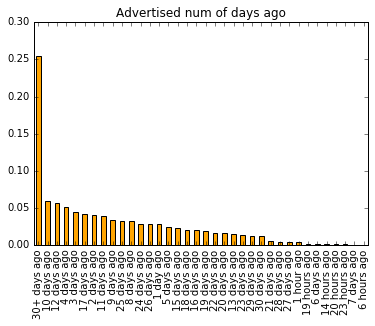

In [51]:
df_joblist.advertised_number_of_days_ago.value_counts(normalize=True).plot(kind='bar',
                                  title="Advertised num of days ago",
                                  color='orange',
                                  align='center')

In [30]:
def compute_advertised_date(row):
    #extract number and identifier (days or hours)
    
    advertised_number = int(re.findall('\d+', row['advertised_number_of_days_ago'])[0])
    
    if re.findall('hour', row['advertised_number_of_days_ago']):
        return row['query_date']
    elif re.findall('day', row['advertised_number_of_days_ago']) and advertised_number == 30:
        return row['query_date'] - pd.Timedelta(days=30) #jobs advertised 30+ days ago also defaulted to 30 days.
    elif re.findall('day', row['advertised_number_of_days_ago']) and advertised_number != 30:            
        return row['query_date'] - pd.Timedelta(days=advertised_number)
    else:
        return None

In [31]:
df_joblist['advertised_date'] = df_joblist.apply (lambda row: compute_advertised_date(row),axis=1)
df_joblist.head(3)

,query_date,jobtitle,companyname,location,advertised_number_of_days_ago,company_rating,company_rating_counts,salary,summary,joblink,job_query_string,advertised_date
0,2016-06-19,Business Analyst,Telstra,Sydney NSW,2 days ago,None,238 reviews,None,The role requires an individual with a proven ...,http://www.indeed.com/rc/clk?jk=1903a01e324a52...,%22test+analyst%22+%22automation%22+%22busines...,2016-06-17
1,2016-06-19,Business Analyst,CSIRO,Australia,10 days ago,None,12 reviews,"$92,000 - $100,000 a year",Liaise with CSIRO business units to identify o...,http://www.indeed.com/rc/clk?jk=acd08454a8c5a5...,%22test+analyst%22+%22automation%22+%22busines...,2016-06-09
2,2016-06-19,"Business Analyst Change Management,Officer",State Street,Sydney NSW,26 days ago,None,783 reviews,None,Analyse information to determine business risk...,http://www.indeed.com/rc/clk?jk=9522e630f71d08...,%22test+analyst%22+%22automation%22+%22busines...,2016-05-24


In [53]:
#df_joblist.advertised_date.value_counts(normalize=True).plot(kind='bar',
#                                  title="Advertised date",
#                                  color='orange',
#                                  align='center')

#### Check how many rows have salaries

In [32]:
df_joblist.salary.isnull().sum()

854

In [46]:
len(df_joblist)

1000

In [47]:
print int(df_joblist.salary.isnull().sum())
print len(df_joblist)

854
1000


So 80% of jobs don't have salary populated

In [33]:
df_joblist.salary.describe()

count                 146
unique                 86
top       $100,000 a year
freq                    6
Name: salary, dtype: object